In [182]:
import glob
# import pyspedas
from pyspedas import time_string, time_double
from pytplot import tplot, get_data, cdf_to_tplot, store_data
import astrospice
# import sunpy 
# import sys
import os
import datetime
import numpy as np
import pandas as pd
import astropy.units as u
from astropy import constants as c
# from scipy import constants as c
import matplotlib.pyplot as plt
from matplotlib import rc
# from astropy.constants import mu0, m_p, k_B
# import sunpy.coordinates as scoords

In [432]:
files = glob.glob(os.path.join("/Users/kaija/repos/kai-psp/Encounters_New/", '*.csv'))
files = np.sort(files)
dfs = [pd.read_csv(file, index_col=None) for file in files]

for df in dfs:
    df['Time'] = [datetime.datetime.strptime(d, '%Y-%m-%d %H:%M:%S.%f') for d in df.Time]

full_df = pd.concat(dfs)

# Flagging Bad Data
# full_df = full_df[full_df['flag'] == 0]
# full_df = full_df[full_df['Ahe] < 0.2]

full_df = full_df.sort_values(by='Time')

In [367]:
full_df.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'Time', 'vr', 'vt', 'vn', 'Np', 'Tp',
       'angle_vb', 'times', 'Br', 'Bt', 'Bn', 'B', 'VA', 'mA', 'timestamp',
       'use_dens', 'polarity', 'sigmac', 'sigmar', 'vA', 'Zp', 'Zm', 'deltav',
       'deltab', 'rA', 'beta', 'lon', 'lat', 'rAU', 'sslon', 'sslat', 'ssrAU',
       'NpR2', 'BrR2', 'Tsun', 'period', 'vra', 'vta', 'vna', 'Na', 'Ta',
       'vap', 'diff', 'Ahe'],
      dtype='object')

In [368]:
full_df.reset_index(drop=True, inplace=True)

# Type1 solar wind is the method using an estimated value of 400 km/s as a threshold for fast solar wind
full_df['type1'] = '1'
cntSSW = 0
cntSASW = 0
cntFSW = 0

# Because 3 types of winds are mutually exclusive, we can inspect them all in the same loop.
# To identify a certain wind type, we require at least 100 consecutive data points equivalent to a 30-minute period in the data.
for index, row in full_df.iterrows():
    if (row['rAU']*u.AU).to(u.Rsun).value > 40:
        cntSSW = cntSASW = cntFSW = 0
        continue

    Magsigmac = np.abs(row['sigmac'])

    # Slow Solar Wind
    if row['vr'] < 400 and Magsigmac < 0.7:
        cntSSW += 1
    else:
        if cntSSW >= 100:
            full_df.loc[index - cntSSW + 1:index, 'type1'] = 'SSW'
        cntSSW = 0

    # Slow Aflvenic Solar Wind 
    if row['vr'] < 400 and Magsigmac > 0.7:
        cntSASW += 1
    else:
        if cntSASW >= 100:
            full_df.loc[index - cntSASW + 1:index, 'type1'] = 'SASW'
        cntSASW = 0

    # Fast Solar Wind
    if row['vr'] > 400 and Magsigmac > 0.7:
        cntFSW += 1
    else:
        if cntFSW >= 100:
            full_df.loc[index - cntFSW + 1:index, 'type1'] = 'FSW'
        cntFSW = 0

In [369]:
# full_df.reset_index(drop=True, inplace=True)

# Type2 solar wind is the method using a precise value 13% of the fastest data as a threshold for fast solar wind
full_df['type2'] = '1'
cntSSW = 0
cntSASW = 0
cntFSW = 0

full_df = full_df.dropna(subset=['rAU', 'vr'])
full_df['rRsun'] = (np.array(full_df.rAU)*u.AU).to(u.Rsun).value
dff = full_df[full_df['rRsun'] > 40]
bin1 = full_df[(full_df['rRsun'] > 10) & (full_df['rRsun'] < 20)]
bin2 = full_df[(full_df['rRsun'] > 20) & (full_df['rRsun'] < 30)]
bin3 = full_df[(full_df['rRsun'] > 30) & (full_df['rRsun'] < 40)]
bins = [bin1, bin2, bin3]

for element in bins:
    percent = np.percentile(element['vr'], 81)
    print(percent)
    
    # Because 3 types of winds are mutually exclusive, we can inspect them all in the same loop.
    # To identify a certain wind type, we require at least 100 consecutive data points equivalent to a 30-minute period in the data.
    for index, row in element.iterrows():

        Magsigmac = np.abs(row['sigmac'])

        # Slow Solar Wind
        if row['vr'] < percent and Magsigmac < 0.7:
            cntSSW += 1
        else:
            if cntSSW >= 100:
                element.loc[index - cntSSW:index-1, 'type2'] = 'SSW'
            cntSSW = 0

        # Slow Aflvenic Solar Wind 
        if row['vr'] < percent and Magsigmac > 0.7:
            cntSASW += 1
        else:
            if cntSASW >= 100:
                element.loc[index - cntSASW:index-1, 'type2'] = 'SASW'
            cntSASW = 0

        # Fast Solar Wind
        if row['vr'] > percent and Magsigmac > 0.7:
            cntFSW += 1
        else:
            if cntFSW >= 100:
                element.loc[index - cntFSW:index-1, 'type2'] = 'FSW'
            cntFSW = 0

# Add data beyond 40 solar radii that isn't being classified 
full_df = pd.concat(bins)
total = [full_df, dff]
full_df = pd.concat(total)

11-Jul-24 15:17:07: C:\Users\kaija\AppData\Local\Temp\ipykernel_4856\520657208.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_df['rRsun'] = (np.array(full_df.rAU)*u.AU).to(u.Rsun).value



367.4980635
358.11395
394.2668800000004


In [370]:
full_df

,Unnamed: 0.1,Unnamed: 0,Time,vr,vt,vn,Np,Tp,angle_vb,times,...,vta,vna,Na,Ta,vap,diff,Ahe,type1,type2,rRsun
849324,107880,107880,2021-04-28 08:45:29.493032,364.22995,44.040000,-73.534360,33.093616,123.858240,140.32732,1.619600e+09,...,-89.491210,-51.642624,0.905060,329.138640,75.471491,0.123524,0.027348,1,1,19.999792
849325,107881,107881,2021-04-28 08:45:32.988273,366.21664,43.370075,-77.283040,32.518673,129.115500,134.04710,1.619600e+09,...,-85.288284,89.633370,0.295974,180.302230,231.643326,0.377879,0.009102,1,1,19.999513
849326,107882,107882,2021-04-28 08:45:36.483513,345.52707,39.330170,-71.709320,55.169144,108.089745,145.07360,1.619600e+09,...,39.443610,-125.537290,0.756028,878.783900,108.842163,0.175002,0.013704,1,1,19.999234
849327,107883,107883,2021-04-28 08:45:39.978814,347.79700,58.934120,-105.182976,53.536972,97.580810,136.51964,1.619600e+09,...,-3.742921,-54.364635,0.680212,1268.609900,159.517747,0.256941,0.012705,1,1,19.998955
849328,107884,107884,2021-04-28 08:45:43.474054,390.39655,61.364872,-127.395010,33.650295,108.583984,127.08875,1.619600e+09,...,-167.072560,33.839730,0.103773,0.001048,710.941250,1.140213,0.003084,1,1,19.998676
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2706460,297001,297001,2022-06-05 23:59:54.869151,273.76080,-20.715841,4.408144,253.215650,23.545465,144.86253,1.654474e+09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,45.359436
2706461,297001,297001,2022-06-05 23:59:54.869151,273.76080,-20.715841,4.408144,253.215650,23.545465,144.86253,1.654474e+09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,45.359436
2706462,297002,297002,2022-06-05 23:59:58.364392,273.98917,-22.418245,6.244288,263.151730,22.975250,142.98040,1.654474e+09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,45.359753
2706463,297002,297002,2022-06-05 23:59:58.364392,273.98917,-22.418245,6.244288,263.151730,22.975250,142.98040,1.654474e+09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,45.359753


In [371]:
# Entropy and Scaled Alpha Particle Density added to dataframe
full_df['Sp'] = full_df.Tp / ((full_df.Np)**(2/3))
full_df['NaR2'] = (full_df.Na*(full_df.rAU**2))

In [372]:
full_df[full_df['type2'] == 'SSW']

,Unnamed: 0.1,Unnamed: 0,Time,vr,vt,vn,Np,Tp,angle_vb,times,...,Na,Ta,vap,diff,Ahe,type1,type2,rRsun,Sp,NaR2
860462,119018,119018,2021-04-28 19:34:19.785015,182.91125,9.513524,-0.252496,2072.57710,22.458664,152.51230,1.619638e+09,...,32.475998,121.15818,24.359609,0.136725,0.015669,SASW,SSW,17.335803,0.138158,0.211078
860463,119019,119019,2021-04-28 19:34:23.280316,182.49194,13.415121,-2.140178,2109.86740,22.778511,153.81770,1.619638e+09,...,33.573715,128.25490,22.092991,0.124332,0.015913,SSW,SSW,17.335614,0.138470,0.218208
860464,119020,119020,2021-04-28 19:34:26.775557,183.69780,14.503549,-8.478797,2117.37200,23.134867,154.57977,1.619638e+09,...,34.928513,104.84171,15.712119,0.088153,0.016496,SSW,SSW,17.335425,0.140304,0.227009
860465,119021,119021,2021-04-28 19:34:30.270857,185.10782,17.968613,-3.546375,2063.04880,24.201767,157.59390,1.619638e+09,...,35.070300,143.03998,19.019972,0.107403,0.016999,SSW,SSW,17.335236,0.149339,0.227925
860466,119022,119022,2021-04-28 19:34:33.766098,184.78530,21.644356,-3.074567,2145.17140,23.751963,158.90855,1.619638e+09,...,25.115444,124.18485,12.810865,0.072061,0.011708,SSW,SSW,17.335047,0.142799,0.163224
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2655412,279985,279985,2022-06-05 07:28:39.509375,239.41293,11.807408,-36.713050,192.30032,30.870956,149.88344,1.654414e+09,...,1.214188,225.68892,37.984533,0.252627,0.006314,SSW,SSW,39.808693,0.926609,0.041614
2655413,279985,279985,2022-06-05 07:28:39.509375,239.41293,11.807408,-36.713050,192.30032,30.870956,149.88344,1.654414e+09,...,NaN,NaN,NaN,NaN,NaN,SSW,SSW,39.808693,0.926609,NaN
2655414,279986,279986,2022-06-05 07:28:43.004676,237.38446,11.023689,-36.210556,206.43109,30.289225,151.17500,1.654414e+09,...,1.706356,183.75047,56.566442,0.377568,0.008266,SSW,SSW,39.809029,0.867171,0.058482
2655415,279986,279986,2022-06-05 07:28:43.004676,237.38446,11.023689,-36.210556,206.43109,30.289225,151.17500,1.654414e+09,...,NaN,NaN,NaN,NaN,NaN,SSW,SSW,39.809029,0.867171,NaN


In [373]:
full_df[full_df['type2'] == 'SASW']

,Unnamed: 0.1,Unnamed: 0,Time,vr,vt,vn,Np,Tp,angle_vb,times,...,Na,Ta,vap,diff,Ahe,type1,type2,rRsun,Sp,NaR2
849518,108074,108074,2021-04-28 08:56:47.574821,345.71155,18.630636,25.413513,25.507912,118.641754,151.31105,1.619600e+09,...,0.193997,-0.000244,-43.748431,0.146550,0.007605,1,SASW,19.945725,13.691603,0.001669
849519,108075,108075,2021-04-28 08:56:51.070122,325.02332,15.162761,57.277203,33.351597,77.344810,149.84317,1.619600e+09,...,0.302539,1413.347800,92.449789,0.306503,0.009071,SASW,SASW,19.945447,7.464833,0.002603
849520,108076,108076,2021-04-28 08:56:54.565362,331.37997,7.544424,49.469322,67.826700,70.020410,159.82378,1.619600e+09,...,0.148749,-0.000069,142.300389,0.472086,0.002193,SASW,SASW,19.945169,4.210085,0.001280
849521,108077,108077,2021-04-28 08:56:58.060663,329.93375,10.893753,41.890953,61.452312,65.700490,159.30482,1.619600e+09,...,0.133406,0.000115,312.007939,1.025617,0.002171,SASW,SASW,19.944890,4.219003,0.001148
849522,108078,108078,2021-04-28 08:57:01.555903,324.98846,3.525664,47.582250,61.729248,78.320366,158.41057,1.619600e+09,...,0.000000,NaN,NaN,NaN,0.000000,SASW,SASW,19.944612,5.014343,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2655868,280137,280137,2022-06-05 07:37:30.789088,269.91647,17.729082,-57.696130,138.717730,34.349550,126.56662,1.654415e+09,...,NaN,NaN,NaN,NaN,NaN,SASW,SASW,39.859733,1.281838,NaN
2655869,280137,280137,2022-06-05 07:37:30.789088,269.91647,17.729082,-57.696130,138.717730,34.349550,126.56662,1.654415e+09,...,NaN,NaN,NaN,NaN,NaN,SASW,SASW,39.859733,1.281838,NaN
2655870,280138,280138,2022-06-05 07:37:34.284389,274.46600,16.835672,-57.625553,136.666640,36.433067,123.15054,1.654415e+09,...,0.781521,139.761050,34.723652,0.214908,0.005718,SASW,SASW,39.860069,1.373159,0.026854
2655871,280138,280138,2022-06-05 07:37:34.284389,274.46600,16.835672,-57.625553,136.666640,36.433067,123.15054,1.654415e+09,...,NaN,NaN,NaN,NaN,NaN,SASW,SASW,39.860069,1.373159,NaN


In [374]:
full_df[full_df['type2'] == 'FSW']

,Unnamed: 0.1,Unnamed: 0,Time,vr,vt,vn,Np,Tp,angle_vb,times,...,Na,Ta,vap,diff,Ahe,type1,type2,rRsun,Sp,NaR2
1352941,103855,103855,2021-11-20 04:52:52.490017,559.39570,-89.243980,124.805824,224.194380,117.214620,137.256000,1.637384e+09,...,16.314917,1596.03380,210.268601,0.591234,0.072771,FSW,FSW,19.999680,3.176133,0.141132
1352942,103856,103856,2021-11-20 04:52:55.985318,557.87067,-96.571830,128.961750,245.063370,120.112160,136.006360,1.637384e+09,...,16.078611,1620.11680,233.233719,0.649797,0.065610,FSW,FSW,19.999318,3.067148,0.139082
1352943,103857,103857,2021-11-20 04:52:59.480559,567.38605,-93.830864,153.203120,196.881760,127.458070,137.261960,1.637384e+09,...,15.266828,1487.43520,214.048869,0.597486,0.077543,FSW,FSW,19.998955,3.766145,0.132056
1352944,103858,103858,2021-11-20 04:53:02.975859,555.47450,-89.136130,129.832550,211.804060,110.825400,138.886020,1.637384e+09,...,14.526010,1824.36620,204.997294,0.571389,0.068582,FSW,FSW,19.998593,3.119008,0.125643
1352945,103859,103859,2021-11-20 04:53:06.471100,548.82780,-90.171750,102.471190,267.978700,115.824220,144.287950,1.637384e+09,...,14.973765,1698.00790,166.851855,0.467987,0.055877,FSW,FSW,19.998231,2.786544,0.129511
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2090101,91548,91548,2022-05-30 16:56:20.618723,415.30652,-8.866300,-124.885925,50.736950,62.865780,37.920643,1.653930e+09,...,NaN,NaN,NaN,NaN,NaN,1,FSW,30.112049,4.587028,NaN
2090102,91548,91548,2022-05-30 16:56:20.618723,415.30652,-8.866300,-124.885925,50.736950,62.865780,37.920643,1.653930e+09,...,1.607163,475.61093,146.427962,0.257573,0.031676,1,FSW,30.112049,4.587028,0.031516
2090103,91549,91549,2022-05-30 16:56:24.113944,424.07788,-1.779791,-139.385380,41.910973,61.360737,44.937410,1.653930e+09,...,NaN,NaN,NaN,NaN,NaN,1,FSW,30.111682,5.085559,NaN
2090104,91549,91549,2022-05-30 16:56:24.113944,424.07788,-1.779791,-139.385380,41.910973,61.360737,44.937410,1.653930e+09,...,2.074698,517.88970,144.698559,0.254334,0.049502,1,FSW,30.111682,5.085559,0.040683


In [179]:
wind = pd.read_csv('SSWv9.csv')
wind

,Time,vr,vt,vn,Np,Tp,angle_vb,vra,vta,vna,...,sslon,sslat,ssrAU,NpR2,BrR2,type1,type2,rRsun,Sp,NaR2
0,2021-08-10 00:04:38.362483,189.03946,16.240656,-10.420573,1019.85160,62.412090,2.074638,220.05908,1.512103,-9.654128,...,89.472367,-3.810367,0.011626,5.768752,-2.465665,SSW,SSW,16.172451,0.615995,0.033840
1,2021-08-10 00:04:40.110103,191.73956,17.029003,-9.931688,1002.07465,64.465576,2.059629,198.64201,5.793653,-18.173940,...,89.383560,-3.810381,0.011626,5.668224,-2.460428,SSW,SSW,16.172490,0.643766,0.048002
2,2021-08-10 00:04:45.353024,187.64200,16.836733,-14.355205,1017.37180,62.030426,2.070920,247.81342,4.691527,-31.889340,...,89.549800,-3.810422,0.011626,5.754835,-2.464490,SSW,SSW,16.172606,0.613223,0.030454
3,2021-08-10 00:04:47.100644,189.20323,14.381642,-15.410533,985.62830,62.755848,2.077607,208.75186,10.077469,-23.850521,...,89.484950,-3.810435,0.011626,5.575303,-2.465602,SSW,SSW,16.172645,0.633644,0.053898
4,2021-08-10 00:04:48.848264,190.81134,20.699009,-12.134439,992.48510,63.394130,2.042068,220.14659,-42.463608,-39.604073,...,89.452394,-3.810449,0.011626,5.614116,-2.459271,SSW,SSW,16.172683,0.637137,0.031350
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3667,2022-09-03 12:41:54.379879,237.43465,-13.949930,-7.142323,990.83685,27.567732,1.679625,230.94560,-7.158613,-14.103833,...,211.761797,2.439669,0.011626,25.319121,-2.709081,SSW,SSW,34.373729,0.277374,0.580815
3668,2022-09-03 12:41:57.875120,234.68066,-14.171917,-3.319971,984.55066,26.824630,1.658073,232.04820,-12.315891,9.164603,...,211.995893,2.439641,0.011626,25.157969,-2.750709,SSW,SSW,34.373374,0.271045,0.438031
3669,2022-09-03 12:42:01.370361,229.96257,-11.438175,-8.471058,1089.96950,25.571585,1.388514,223.43971,-2.275886,-2.896630,...,212.242886,2.439614,0.011626,27.851135,-2.692608,SSW,SSW,34.373020,0.241443,0.730364
3670,2022-09-03 12:42:04.865662,231.30360,-14.662701,-4.024042,1040.56920,25.728490,1.613849,229.65690,-9.086214,-6.095625,...,212.199938,2.439586,0.011626,26.588300,-2.848708,SSW,SSW,34.372665,0.250553,0.636352


In [214]:
wind.columns

Index(['Time', 'vr', 'vt', 'vn', 'Np', 'Tp', 'angle_vb', 'vra', 'vta', 'vna',
       'Na', 'Ta', 'Br', 'Bt', 'Bn', 'Ne', 'B', 'vap', 'Ahe', 'sigmac',
       'sigmar', 'vA', 'Zp', 'Zm', 'deltav', 'deltab', 'diff', 'MA', 'beta',
       'Pm', 'Pp', 'Pa', 'flag', 'lon', 'lat', 'rAU', 'sslon', 'sslat',
       'ssrAU', 'NpR2', 'BrR2', 'type1', 'type2', 'rRsun', 'Sp', 'NaR2'],
      dtype='object')

11-Jul-24 15:35:36: C:\Users\kaija\AppData\Local\Temp\ipykernel_4856\4048307874.py:1: DtypeWarning: Columns (41,42) have mixed types. Specify dtype option on import or set low_memory=False.
  wind = pd.read_csv('WINDv6.csv')

11-Jul-24 15:35:39: Substituting symbol \odot from Computer Modern
11-Jul-24 15:35:39: Substituting symbol \odot from Computer Modern
11-Jul-24 15:35:39: Substituting symbol \odot from Computer Modern
11-Jul-24 15:35:39: Substituting symbol \odot from Computer Modern
11-Jul-24 15:35:39: Substituting symbol \odot from Computer Modern
11-Jul-24 15:35:39: Substituting symbol \odot from Computer Modern
11-Jul-24 15:35:39: Substituting symbol \odot from Computer Modern
11-Jul-24 15:35:39: Substituting symbol \odot from Computer Modern
11-Jul-24 15:35:39: Substituting symbol \odot from Computer Modern
11-Jul-24 15:35:39: Substituting symbol \odot from Computer Modern
11-Jul-24 15:35:39: Substituting symbol \odot from Computer Modern
11-Jul-24 15:35:39: Substituting symb

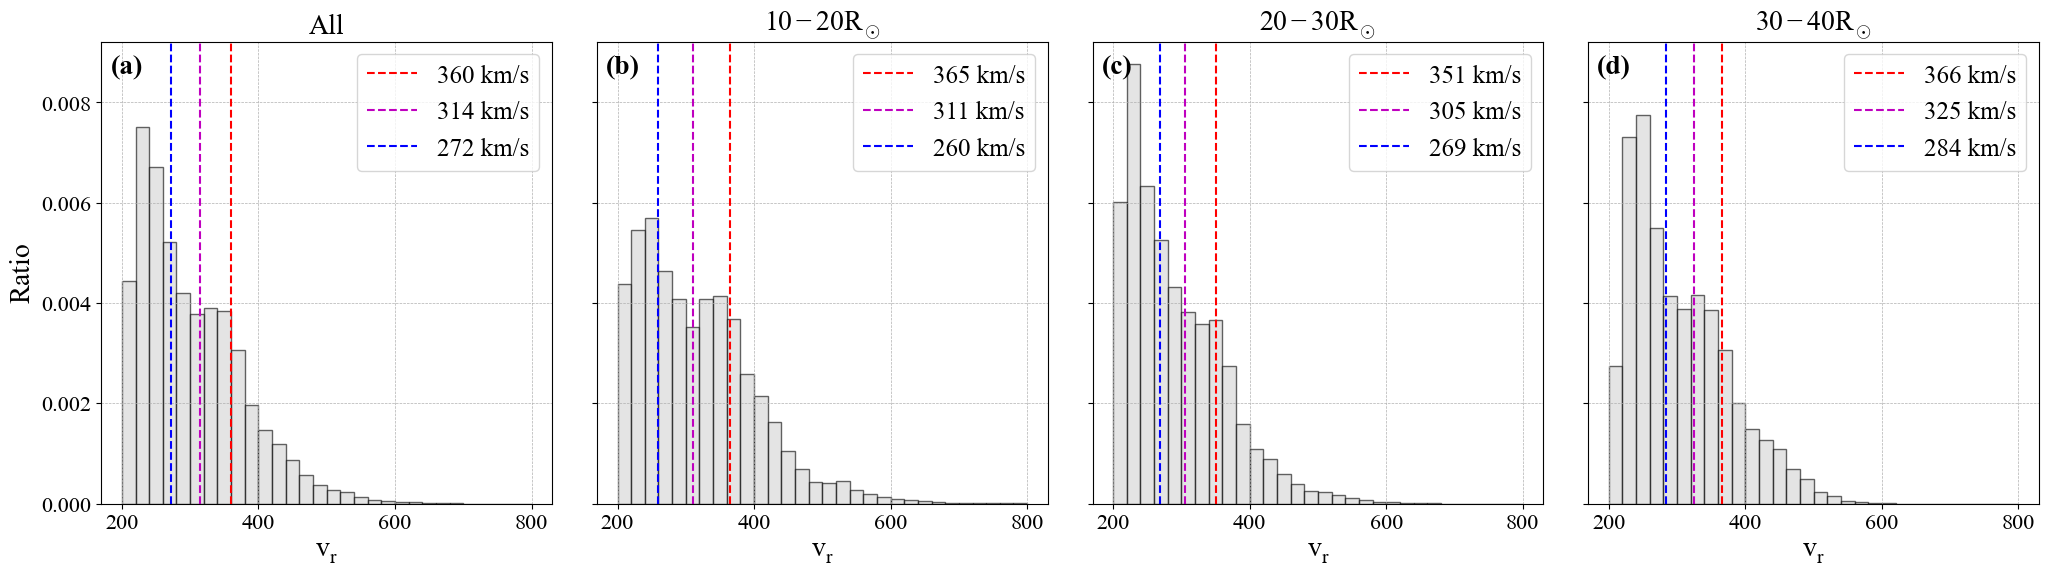

In [394]:
wind = pd.read_csv('WINDv6.csv')
wind['rRsun'] = (np.array(wind.rAU)*u.AU).to(u.Rsun).value
wind = wind[wind['rRsun'] < 40]
bin1 = wind[(wind['rRsun'] > 10) & (wind['rRsun'] < 20)]
bin2 = wind[(wind['rRsun'] > 20) & (wind['rRsun'] < 30)]
bin3 = wind[(wind['rRsun'] > 30) & (wind['rRsun'] < 40)]


bins = [wind, bin1, bin2, bin3]
bin_type = ['All', r'$\rm 10 - 20 R_\odot$', r'$\rm 20 - 30 R_\odot$', r'$\rm 30 - 40 R_\odot$']
texts = ['(a)', '(b)', '(c)', '(d)']

fig, axs = plt.subplots(1, 4, figsize=(25, 6), sharex='all', sharey='all', gridspec_kw={'hspace': 0.1, 'wspace': 0.1})

# Go through each wind type list and create an appropriate plot for each of them
# Use LaTeX formatting to label plots with appropriate variable names
for i, file in enumerate(bins):
    df = file
    df = df.dropna(subset=['rRsun', 'vr'])

    axs[i].hist(df.vr, bins=30, range = [200,800], density=True, alpha=0.6, color='lightgrey', edgecolor='k')

    rc('font', **{'family': 'serif', 'serif': ['Times New Roman']})
    rc('mathtext', fontset='custom', rm='Times New Roman', it='Times New Roman:italic', bf='Times New Roman:bold')
    plt.rcParams['font.size'] = 18
    axs[0].set_ylabel(r'$\rm Ratio$', fontsize=20)
    axs[i].set_xlabel(r'$\rm v_r$', fontsize=20)
    axs[i].set_title(bin_type[i], fontsize=20)
    axs[i].grid(True, linestyle='--', linewidth=0.5)
    axs[i].tick_params(axis='both', which='major', labelsize=16)
    axs[i].text(0.02, 0.97, texts[i], transform=axs[i].transAxes, fontsize=20, fontweight='bold', va='top', ha='left')
    
    # lines at upper: ('19%', '35%', '51%')
    percent1 = round(np.percentile(df['vr'], 81))
    axs[i].axvline(percent1, linestyle='dashed', color='r')
    percent2 = round(np.percentile(df['vr'], 65))
    axs[i].axvline(percent2, linestyle='dashed', color='m')
    percent3 = round(np.percentile(df['vr'], 49))
    axs[i].axvline(percent3, linestyle='dashed', color='b')

    axs[i].legend([str(percent1) + ' km/s', str(percent2) + ' km/s', str(percent3) + ' km/s'])

plt.savefig(os.path.join("/Users/kaija/OneDrive/Pictures/Publication Figures", 'velocity_histogram.png'), bbox_inches = 'tight')
plt.savefig(os.path.join("/Users/kaija/OneDrive/Pictures/Publication Figures", 'velocity_histogram.pdf'), bbox_inches = 'tight')

12-Jul-24 10:26:06: C:\Users\kaija\AppData\Local\Temp\ipykernel_4856\2078485181.py:11: DtypeWarning: Columns (36) have mixed types. Specify dtype option on import or set low_memory=False.
  wind = pd.read_csv(file)

12-Jul-24 10:26:13: C:\Users\kaija\AppData\Local\Temp\ipykernel_4856\2078485181.py:11: DtypeWarning: Columns (36) have mixed types. Specify dtype option on import or set low_memory=False.
  wind = pd.read_csv(file)



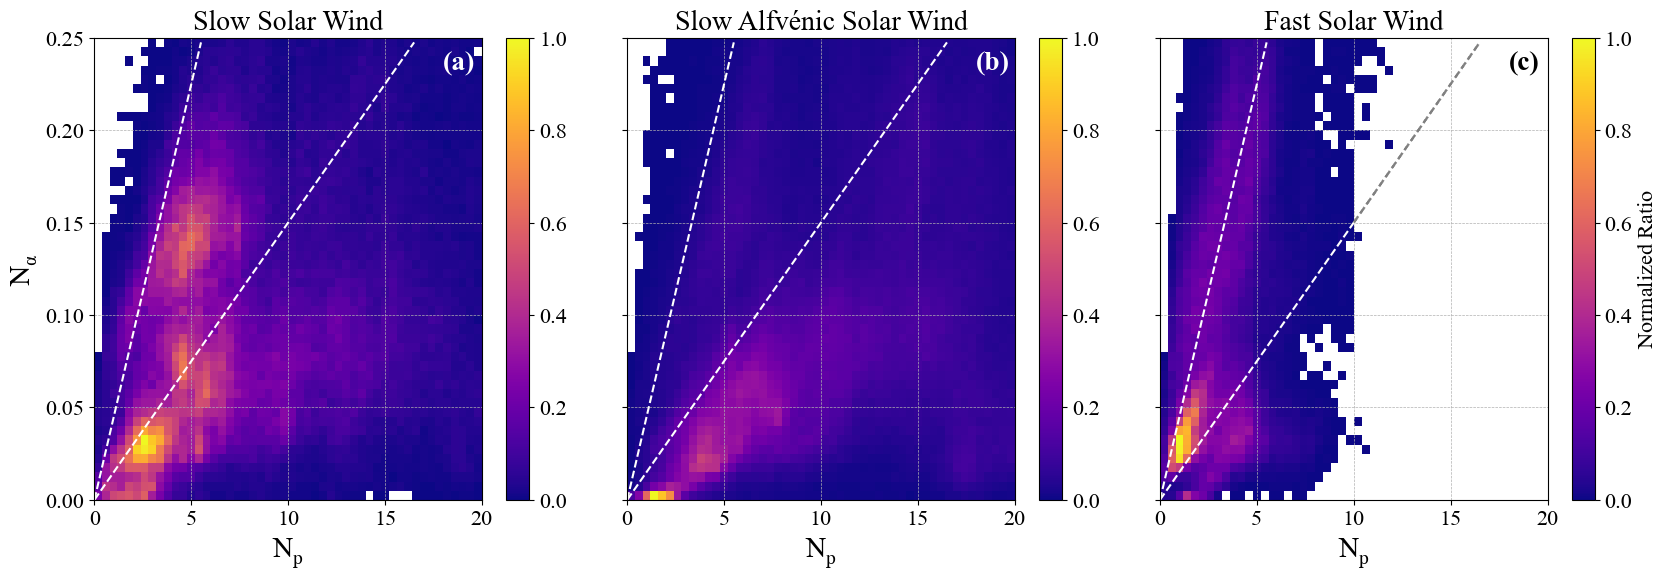

In [479]:
wind_types = ['Slow Solar Wind', 'Slow Alfvénic Solar Wind', 'Fast Solar Wind']
wind_files = ['SSWv9.csv', 'SASWv9.csv', 'FSWv9.csv']
colors = ['white', 'white', 'black']
texts = ['(a)', '(b)', '(c)']

fig, axs = plt.subplots(1, 3, figsize=(20, 6), sharex='all', sharey='all', gridspec_kw={'hspace': 0.1, 'wspace': 0.1})

# Go through each wind type list and create a normalized plot for each of them
# Use LaTeX formatting to label plots with appropriate variable names
for i, file in enumerate(wind_files):
    wind = pd.read_csv(file)

    wind = wind.dropna(subset=['NpR2', 'NaR2'])
    hist, xedges, yedges = np.histogram2d(wind.NpR2, wind.NaR2, bins=(50,50), range = [[0,20], [0, 0.25]])
    hist_normalized = hist / hist.max()
    hist_normalized[hist_normalized == 0.0] = np.nan
    im = axs[i].imshow(hist_normalized.T, extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], cmap='plasma', origin='lower', aspect='auto', vmin=0, vmax=1)

    rc('font', **{'family': 'serif', 'serif': ['Times New Roman']})
    rc('mathtext', fontset='custom', rm='Times New Roman', it='Times New Roman:italic', bf='Times New Roman:bold')
    plt.rcParams['font.size'] = 18
    axs[0].set_ylabel(r'$\rm N_\alpha$', fontsize=20)
    axs[i].set_xlabel(r'$\rm N_p$', fontsize=20)
    axs[i].set_title(wind_types[i], fontsize=20)
    axs[i].grid(True, linestyle='--', linewidth=0.5)
    axs[i].tick_params(axis='both', which='major', labelsize=16)
    axs[i].text(0.9, 0.97, texts[i], transform=axs[i].transAxes, fontsize=20, color=colors[i],  fontweight='bold', va='top', ha='left')
    cbar = fig.colorbar(im, ax=axs[i])
    cbar.ax.yaxis.label.set_fontsize(16)
    cbar.ax.tick_params(labelsize=16)

    # Adding Helium Abundnace Boundaries
    slope = 0.015
    x = np.linspace(0,16.5)
    y = slope*x
    axs[i].plot(x,y, color='white', linestyle='--')
    slope = 0.015
    x = np.linspace(10,16.5)
    y = slope*x
    axs[2].plot(x,y, color='grey', linestyle='--')
    slope = 0.045
    x = np.linspace(0,5.5)
    y = slope*x
    axs[i].plot(x,y, color='white', linestyle='--')
    
cbar.ax.set_ylabel(r'$\rm Normalized \ Ratio $')
plt.savefig(os.path.join("/Users/kaija/OneDrive/Pictures/Publication Figures", 'helium_abundance.png'), bbox_inches = 'tight')
plt.savefig(os.path.join("/Users/kaija/OneDrive/Pictures/Publication Figures", 'helium_abundance.pdf'), bbox_inches = 'tight')

12-Jul-24 10:26:19: C:\Users\kaija\AppData\Local\Temp\ipykernel_4856\2173377887.py:11: DtypeWarning: Columns (36) have mixed types. Specify dtype option on import or set low_memory=False.
  wind = pd.read_csv(file)

12-Jul-24 10:26:26: C:\Users\kaija\AppData\Local\Temp\ipykernel_4856\2173377887.py:11: DtypeWarning: Columns (36) have mixed types. Specify dtype option on import or set low_memory=False.
  wind = pd.read_csv(file)



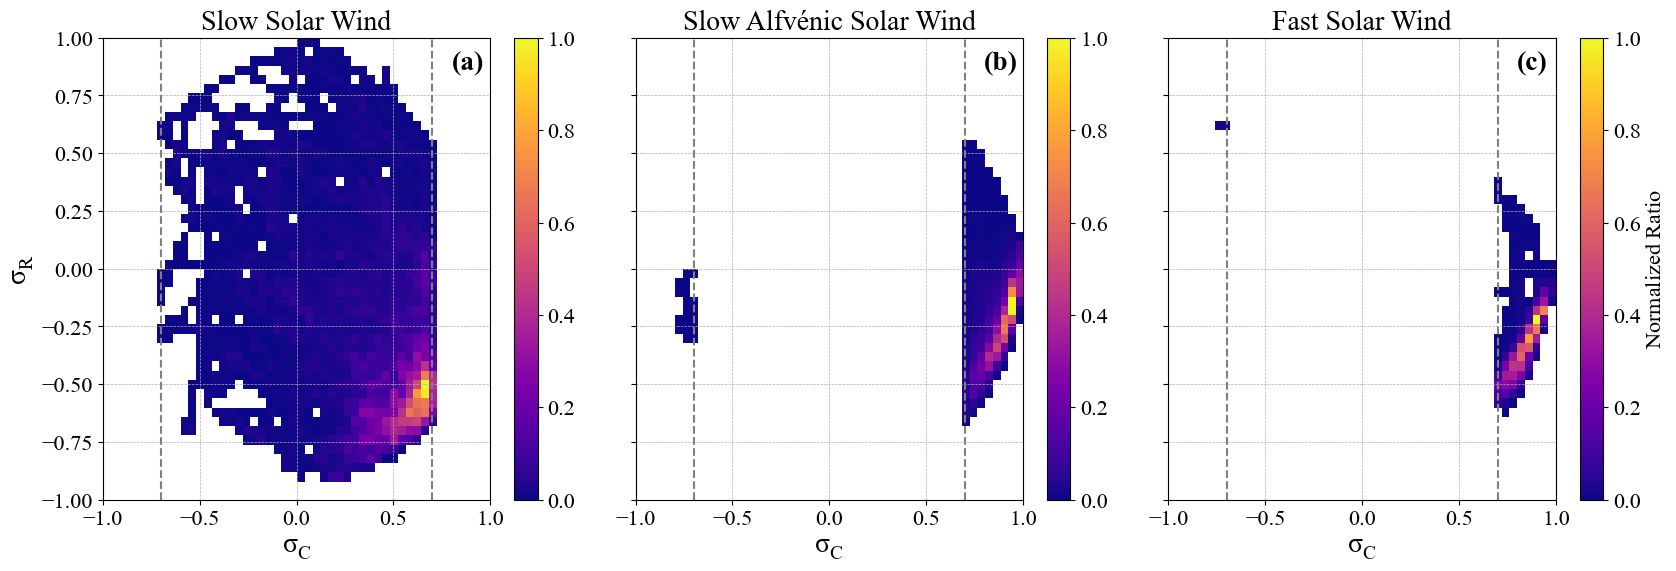

In [480]:
wind_types = ['Slow Solar Wind', 'Slow Alfvénic Solar Wind', 'Fast Solar Wind']
wind_files = ['SSWv9.csv', 'SASWv9.csv', 'FSWv9.csv']
texts = ['(a)', '(b)', '(c)']

fig, axs = plt.subplots(1, 3, figsize=(20, 6), sharex='all', sharey='all', gridspec_kw={'hspace': 0.1, 'wspace': 0.1})

# Go through each wind type list and create a normalized plot for each of them
# Use LaTeX formatting to label plots with appropriate variable names
for i, file in enumerate(wind_files):
    wind = pd.read_csv(file)

    wind = wind.dropna(subset=['sigmac', 'sigmar'])
    hist, xedges, yedges = np.histogram2d(wind.sigmac, wind.sigmar, bins=(50,50), range = [[-1,1], [-1, 1]])
    hist_normalized = hist / hist.max()
    hist_normalized[hist_normalized == 0.0] = np.nan
    im = axs[i].imshow(hist_normalized.T, extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], cmap='plasma', origin='lower', aspect='auto', vmin=0, vmax=1)

    axs[i].axvline(0.7, linestyle='dashed', color='grey')
    axs[i].axvline(-0.7, linestyle='dashed', color='grey')

    rc('font', **{'family': 'serif', 'serif': ['Times New Roman']})
    rc('mathtext', fontset='custom', rm='Times New Roman', it='Times New Roman:italic', bf='Times New Roman:bold')
    plt.rcParams['font.size'] = 18
    axs[0].set_ylabel(r'$\rm \sigma_R$', fontsize=20)
    axs[i].set_xlabel(r'$\rm \sigma_C$', fontsize=20)
    axs[i].set_title(wind_types[i], fontsize=20)
    axs[i].grid(True, linestyle='--', linewidth=0.5)
    axs[i].tick_params(axis='both', which='major', labelsize=16)
    axs[i].text(0.9, 0.97, texts[i], transform=axs[i].transAxes, fontsize=20, color='black',  fontweight='bold', va='top', ha='left')
    cbar = fig.colorbar(im, ax=axs[i])
    cbar.ax.yaxis.label.set_fontsize(16)
    cbar.ax.tick_params(labelsize=16)
    
cbar.ax.set_ylabel(r'$\rm Normalized \ Ratio $')
plt.savefig(os.path.join("/Users/kaija/OneDrive/Pictures/Publication Figures", 'Sigmac_Sigmar.png'), bbox_inches = 'tight')
plt.savefig(os.path.join("/Users/kaija/OneDrive/Pictures/Publication Figures", 'Sigmac_Sigmar.pdf'), bbox_inches = 'tight')